In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

input_ = pd.read_csv("AAPL.csv") #AAPL berada di Files (gambar files sebelah kri)
input_.head()

,Date,Close,Open,High,Low,Volume
0,1/17/2020,138.31,136.54,138.330,136.16,5623336
1,1/16/2020,137.98,137.32,138.190,137.01,4320911
2,1/15/2020,136.62,136.00,138.055,135.71,4045952
3,1/14/2020,135.82,136.28,137.139,135.55,3683458
4,1/13/2020,136.60,135.48,136.640,135.07,3531572


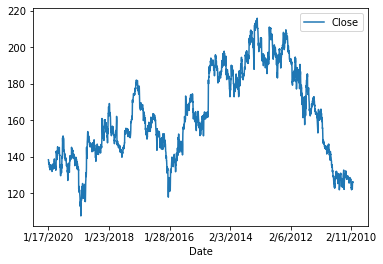

In [3]:
input_.plot("Date","Close")
plt.show()

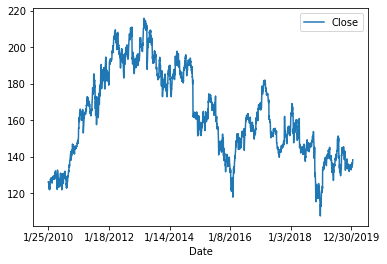

In [4]:
input_ = input_.sort_index(ascending=False)
input_.plot("Date","Close")
plt.show()

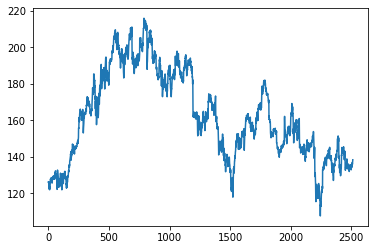

In [5]:
ts_data = input_.Close.values.reshape(-1,1)
plt.plot(ts_data)
plt.show()

In [6]:
train_records = int(len(ts_data)*0.75)
print(train_records)
print(ts_data.shape)

1885
(2514, 1)


In [7]:
train_data = ts_data[:train_records]
test_data = ts_data[train_records:]
print(len(train_data))
print(len(test_data))

1885
629


In [8]:
scaler = MinMaxScaler()
train_scale = scaler.fit_transform(train_data)
test_scale = scaler.transform(test_data)

#PREPARE
def get_lookback(inp,lookback):
  y = pd.DataFrame(inp)
  dataX = [y.shift(i) for i in range(1,lookback+1)]
  dataX = pd.concat(dataX, axis = 1)
  dataX.fillna(0,inplace=True)
  return dataX.values, y.values

lookback = 10
train_X, train_Y = get_lookback(train_scale,lookback)
test_X, test_Y = get_lookback(test_scale, lookback)

test_X.shape

(629, 10)

In [9]:
#RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Activation, Dropout, Dense, Reshape

model = Sequential()
model.add(Reshape((lookback,1), input_shape = (lookback,)))
model.add(SimpleRNN(32, input_shape=(lookback, 1))) #32 jmlh neuron
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error',
              optimizer='adam')

model.summary() # 32*32 + 32*1 + 32*1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 10, 1)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1088      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(train_X, train_Y,
                    epochs=3, batch_size=1, 
                    verbose=2, validation_split=0.1)

Epoch 1/3
1696/1696 - 4s - loss: 0.0026 - val_loss: 6.9033e-04
Epoch 2/3
1696/1696 - 3s - loss: 0.0011 - val_loss: 4.5672e-04
Epoch 3/3
1696/1696 - 4s - loss: 9.9849e-04 - val_loss: 6.1308e-04


In [11]:
import math

def get_model_perf(model_obj):
    score_train = model_obj.evaluate(train_X, train_Y, verbose=0)
    print('Train RMSE: %.2f RMSE' % (math.sqrt(score_train)))
    score_test = model_obj.evaluate(test_X, test_Y, verbose=0)
    print('Test RMSE: %.2f RMSE' % (math.sqrt(score_test)))

get_model_perf(model)

Train RMSE: 0.03 RMSE
Test RMSE: 0.03 RMSE


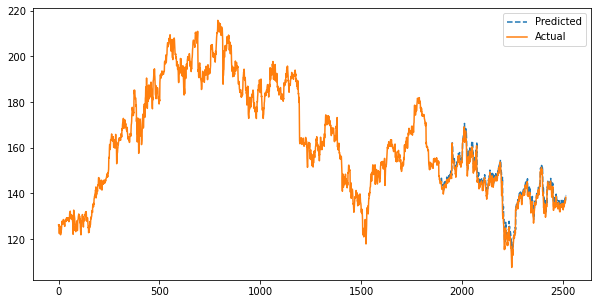

In [12]:
def plot_pred(model_obj):
    testPredict = scaler.inverse_transform(model_obj.predict(test_X))
    pred_test_plot = ts_data.copy()
    pred_test_plot[:train_records+lookback,:] = np.nan
    pred_test_plot[train_records+lookback:,:] = testPredict[lookback:]
    plt.plot(pred_test_plot, "--")
    plt.plot(ts_data)
    plt.legend({"Predicted", "Actual"},loc=1)
    

plt.figure(figsize=[10,5])
plot_pred(model)
plt.show()